# Automatic Identification of Human Blastocyst Components via Texture
> P. Saeedi, D. Yee, J. Au and J. Havelock, "Automatic Identification of Human Blastocyst Components via Texture," in IEEE Transactions on Biomedical Engineering, vol. 64, no. 12, pp. 2968-2978, Dec. 2017, doi: [10.1109/TBME.2017.2759665](https://ieeexplore.ieee.org/document/8059868).

They introduce an algorithm for automatic sementation of two man components of human blastocysts named: Trophectoderm (TE) and the inner cell mass (ICM). They utilize texture information along the biological and physucal characteristics of day-5 embryos to identify TE and ICM regions.


In [1]:
import cv2,os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
import statistics
import sys
from glob import glob
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.filters.rank.generic import threshold
from skimage import filters 
from skimage.filters.rank import entropy
from skimage.morphology import disk
from pathlib import Path

In [2]:
sys.path.insert(1, '../utils/phasepack')
from phasepack import phasecong
sys.path.insert(1, '../utils/')
from zp_detection import *
sys.path.insert(1, '../utils/')
from edgelkg import *

## A. Blastocyst Structural Model

In [3]:
def regs(mask):
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(cnts[0])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    r = radio(S_p(mask==255),(cX,cY))
    reg3= mask - cv2.circle(np.zeros(mask.shape), (cX,cY), round(r*0.8), (255,0,0), -1)
    reg2= mask - cv2.circle(np.zeros(mask.shape), (cX,cY), round(r*0.6), (255,0,0), -1) - reg3
    reg1= mask-reg2-reg3
    return reg1, reg2, reg3

## B. Texture Analysis

### 1. Quantitative Texture Measure

Local standard deviation, Haralick: Contrast, Local Homogeneity and Global Homogeneity

In [4]:
def local_sd(img):
    return generic_filter(img, np.std, size=3)

def levels(img, levels=9):
    img= ((img - np.min(img)) / (np.max(img) - np.min(img)))*(levels-1)
    return img.astype('uint8')

def harlick (img,mask,N=3): #mask dtype=bool
    comatrix=levels(img)
    y,x=img.shape
    contraste_final, l_hom_final, g_hom_final=np.zeros((y,x)), np.zeros((y,x)), np.zeros((y,x))
    for i in range(1,x-1):
        for j in range(1,y-1):
            if mask[j,i]:
                comat_N=graycomatrix(comatrix[j-1:j+1,i-1:i+1], [1], [0], levels=9)
                c = graycoprops(comat_N, 'contrast')
                l_hom = graycoprops(comat_N, 'homogeneity')
                g_hom = graycoprops(comat_N, 'ASM')
                contraste_final[j,i],l_hom_final[j,i], g_hom_final[j,i]=c[0][0], l_hom[0][0], g_hom[0][0]
    return contraste_final,l_hom_final,g_hom_final

In [5]:
def textures(img,mask): #mask dtype=bool
    # LOCAL STANDARD DEVIATION
    lsd=local_sd(img)
    # ENTROPY
    entr = entropy(img, disk(5))
    # CONTRAST, LOCAL HOMOGENEITY & GLOBAL HOMOGENEITY
    contraste,l_hom,g_hom=harlick(img,mask)
    return lsd, entr, contraste, l_hom, g_hom

### 2. Texture Mask via K-means

In [6]:
def kmeans(img, mask): #mask dtype= bool
    lsd, entr, contraste, l_hom, g_hom = textures (img,mask)
    lsd_mask,entr_mask,contr,l_hom_mask,g_hom_mask=lsd[mask],entr[mask],contraste[mask],l_hom[mask],g_hom[mask]
    # descriptors, just considering the pixels inside the blastocyst
    desc=np.array([[lsd_mask[k], entr_mask[k], contr[k], l_hom_mask[k], g_hom_mask[k]] for k in range(len(lsd[mask]))])
    kmeans = KMeans(n_clusters=2, random_state=0).fit(desc)
    texturas=kmeans.labels_+1
    clusters=np.zeros(img.shape)
    clusters[mask]=texturas
    counts=list(np.unique(texturas,return_counts=True)[1])
    # smooth cluster 
    c_smooth=counts.index(max(counts))+1
    # textured cluster
    c_tex=counts.index(min(counts))+1
    return (clusters,c_tex,c_smooth)

### 3. Segmentation via Watershed Algorithm

In [7]:
def watershed_seg(img,mask): #mask dtype bool
    thresh_nucleo=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] 
    dist = ndi.distance_transform_edt(thresh_nucleo)
    dist_visual = dist.copy()
    local_max=peak_local_max(dist, min_distance=1, labels=thresh_nucleo)
    mask_ = np.zeros(dist.shape, dtype=bool)
    mask_[tuple(local_max.T)] = True
    markers, _ = ndi.label(mask_)
    markers = cv2.watershed(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB),markers)
    markers[mask==False]=-2
    return markers

In [8]:
def pc_values(img):
    _,_,_,_,PC,_,_=phasecong(img,norient=6)
    PC=np.array(PC)
    y,x=img.shape
    pc_reg=np.zeros((y,x))
    for i in range(x):
        for j in range(y):
            pc_reg[j,i]=max(PC[:,j,i])
    return pc_reg

def probability(markers,pc,tex):
    prob=np.zeros(markers.shape)
    for i in range(np.unique(markers)[-1]):
        prob[markers==i]=sum(pc[np.logical_and(markers==i,tex)])/sum(sum(markers==i))
    return prob

In [9]:
def region_classification(tex,smth,markers,pc,prob):
    #tex --> mask cluster texture
    #smooth --> mask cluster smooth
    textured,smooth=np.full(markers.shape,False),np.full(markers.shape,False)
    m1,s1=np.mean(pc[tex]),np.std(pc[tex])
    m2,s2=np.mean(pc[smth]),np.std(pc[smth])
    textured = prob>m1-s1
    smooth = prob< m2+s2
    smooth[markers==-1]=False
    smooth[markers==-2]=False
    return (m1,m2,textured,smooth)

### Pipeline Texture Analysis

In [10]:
def texture_analysis(img, mask):
    mask=mask==255
    lsd, entr, contraste, l_hom, g_hom = textures (img,mask)
    clusters,c_tex,c_smooth = kmeans(img, mask)
    cluster_tex=cv2.dilate(255*(clusters==c_tex).astype('uint8'),np.ones((3,3)))
    cluster_smth=cv2.erode(255*(clusters==c_smooth).astype('uint8'),np.ones((3,3)))
    markers=watershed_seg(img,mask)
    pc=pc_values(img)
    prob=probability(markers,pc,cluster_tex==255)
    m1,m2,textured,smooth = region_classification(cluster_tex==255,cluster_smth==255,markers,pc,prob)
    return markers,pc,prob,m1,m2,textured,smooth

## C. Blastocyst Component Identification
### 1. ICM and TE Regions Initialization
#### 1.1. Blastocyst Region Seed Identification

In [11]:
def seed(reg,markers,clase):
    s=np.zeros(markers.shape,dtype='uint8')
    s[clase]=reg[clase]
    for i in np.unique(markers[s==255]):
        if np.count_nonzero(s[markers==i]) > np.count_nonzero(markers==i)*0.8:
            s[markers==i]=255
    return cv2.morphologyEx(s, cv2.MORPH_CLOSE, np.ones((3,3)))

#### 1.2. Region Merging and Classification

In [12]:
def strong_weak_bound(pc, markers_seed):
    #returns midpoint between strong and weak boundaries
    th_b=np.zeros(pc.shape)
    th_solo_pc=cv2.threshold(equalize(pc[markers_seed==-1]),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] 
    th_b[markers_seed==-1]=th_solo_pc.flatten()
    return (np.mean(pc[th_b==255])+ np.mean(pc[th_b==0]))/2

def merging(dic,m1,m2,markers_seed,pc,prob):
    mid = strong_weak_bound(pc, markers_seed)
    for el in dic:
        val=np.mean(pc[markers_seed==dic[el]['idx']])
        nh=[n for n in np.unique(markers_seed[dic[el]['reg']==255]) if n>=0]
        for i in nh:
            p=prob[markers_seed==i][0]
            #condicion 1
            if abs(p-val) < (m1+m2)/2:
            #condicion 2
                trocito= cv2.dilate(255*(markers_seed==i).astype('uint8'), np.ones((5,5)))
                if dic[el]['idx'] in markers_seed[trocito==255]:
                    semilla = cv2.dilate(255*(markers_seed==dic[el]['idx']).astype('uint8'), np.ones((5,5)))
                    borde = cv2.bitwise_and(trocito,semilla)
                    borde = np.logical_and(borde==255, markers_seed==-1)
                    if np.mean(pc[borde]) < mid :
                        markers_seed[markers_seed==i]=dic[el]['idx'] 
                        markers_seed[borde]=dic[el]['idx'] 
    return markers_seed

In [13]:
def seed_merging(markers,textured,m1,m2,pc,prob,dic):
    TE=seed(dic['TE']['reg'],markers,textured)
    ICM=seed(dic['ICM']['reg'],markers,textured)
    markers_seed= markers.copy()
    markers_seed[TE==255]=dic['TE']['idx']
    markers_seed[ICM==255]=dic['ICM']['idx']
    markers_seed=merging(dic,m1,m2,markers_seed,pc,prob)
    return markers_seed

### TE Segmentation

In [14]:
def dark_reg(img,mask,reg2,reg3, markers_seed, pc):
    # All points between the dark edges and the inner ZP are TE
    TE=255*(markers_seed==-3).astype('uint8')
    dilated_mask=dilating(mask,7)
    zp=dilated_mask-mask
    TE_zp=TE+zp
    # cond 1
    points_te=255* np.logical_and(reg2+reg3==255, img < np.mean(img[TE==255])).astype('uint8')
    _, labels = cv2.connectedComponents(points_te+TE_zp)
    # cond 2
    cond1=255*(labels==labels[points_te==255][0]).astype('uint8')
    cond1[cond1==255]=255*(pc[cond1==255] > np.mean(pc[TE==255])).astype('uint8')
    _, labels = cv2.connectedComponents(TE_zp+cond1)
    return labels==labels[TE_zp==255][0]

In [15]:
def edge_linking(gray_img):
    # Convert the gray_img to gray
    kernel_size = 7                                        # Kernel size for the Gaussian Blur
    blur_gray = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 2)
    low_threshold = 35                                     # Low threshold for Canny edge
    high_threshold = 60                                    # High threshold for Canny edge
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    A = edgelink(edges, 200)                               # 200 means nothing here. Don't mind it.
    A.get_edgelist()
    edgelist = A.edgelist
    etype = A.etype
    nedgelist = cleanedgelist(edgelist.copy(), 20)
    tol = 4
    sedgelist = seglist(nedgelist, tol)                    # Extract critical points of each edge class
    fedgelist = cleanedgelist(sedgelist.copy(), 20)
    return nedgelist

def edge_map(img,mask,reg2,reg3, markers_seed,pc):
    candidatos=255*dark_reg(img,mask,reg2,reg3, markers_seed,pc).astype('uint8')
    TE=255*(markers_seed==-3).astype('uint8')
    candidatos[mask==0]=0
    edge_list=edge_linking(candidatos)
    edg=np.zeros(img.shape,'uint8')
    Nedge=len(edge_list)
    for idx in range(Nedge):
        edg[edge_list[idx][:, 0],edge_list[idx][:, 1]]=255
    num_labels, labels = cv2.connectedComponents(edg)
    points=np.zeros(labels.shape,'uint8')
    region=dilating(TE,3)
    for i in range(1,num_labels): 
        if sum(sum(np.logical_and(region==255, labels==i))) >0:
            points[labels==i]=255
    return cv2.bitwise_or(candidatos,points)

In [16]:
def te_segmentation(img,mask,reg2,reg3, markers_seed,pc):
    te=edge_map(img,mask,reg2,reg3, markers_seed,pc)
    zp=dilating(mask,7)-mask
    te=te+zp
    closing = cv2.morphologyEx(te, cv2.MORPH_CLOSE, np.ones((5,5)))
    peri=closing - cv2.erode(closing,np.ones((3,3))) 
    _, labels = cv2.connectedComponents(peri)
    count=list(np.unique(labels,return_counts=True)[1])
    ar= count.copy()
    ar.sort() 
    edges=255*(labels==count.index(ar[-2])).astype('uint8')
    edges[mask==0]=0
    return edges

## Pipeline

In [17]:
def te_pipeline(img,mask,markers_seed, pc):
    reg1, reg2, reg3 = regs(mask)
    te_edges=te_segmentation(img,mask,reg2,reg3, markers_seed, pc)
    inner_line=dilating(mask)-mask
    _, labels = cv2.connectedComponents(255-te_edges-inner_line)
    idx=statistics.mode(labels[reg1==255])
    return 255*np.logical_xor(labels==idx, mask==255).astype('uint8')

### ICM Segmentation

In [18]:
def icm_pipeline(te_edges, markers_seed, mask, pc, m1,m2, textured):
    i_mass=cv2.bitwise_and(255 - te_edges, mask)
    if np.unique(markers_seed==-4).shape[0]==1:
        not_te=cv2.bitwise_not(te_edges)
        markers_seed[np.logical_and(not_te==255, textured)]=-4
    if np.unique(markers_seed==-4).shape[0]==1:
        return i_mass
    markers_seed[ndimage.binary_fill_holes(markers_seed==-4)]=-4
    markers_seed[i_mass==0]=-2
    val=np.mean(pc[markers_seed==-4])
    ant=np.full(mask.shape,False)
    k=0
    while sum(sum(np.logical_xor(ant,markers_seed==-4)))!=0 and k<20:
        k+=1
        ant=(markers_seed==-4).copy()
        for i in [x for x in np.unique(markers_seed[i_mass==255]) if x>=0]:
            if abs(np.mean(pc[markers_seed==i]) - val) < (m1-m2)/2:
                mascara=dilating(255*(markers_seed==i).astype('uint8'),5)
                if -4 in markers_seed[mascara==255]:
                    #markers_seed[markers_seed==i]=-4  
                    markers_seed[mascara==255]=-4 
                    markers_seed[ndimage.binary_fill_holes(markers_seed==-4)]=-4
    icm=255*(markers_seed==-4).astype('uint8')
    icm=cv2.erode(icm, np.ones((3,3)))
    icm_peri=dilating(icm)-icm
    _, labels = cv2.connectedComponents(255- icm_peri)
    idx=statistics.mode(labels[markers_seed==-4])
    return 255*(labels==idx).astype('uint8')

# PIPELINE

In [19]:
def pipeline(path):
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask=innerModel(path)
    img[mask==0]=0
    img=cv2.equalizeHist(img)
    reg1, reg2, reg3 = regs(mask)
    markers,pc,prob,m1,m2,textured,smooth = texture_analysis(img, mask)
    dic={'TE':{'idx':-3,'reg':reg3,'tex':textured}, 'ICM':{'idx':-4, 'reg':reg1,'tex':textured}}
    markers_seed=seed_merging(markers,textured,m1,m2,pc,prob,dic)
    te  =te_pipeline(img,mask,markers_seed, pc)
    icm =icm_pipeline(te, markers_seed, mask,pc,m1,m2,textured)
    return te,icm

# METRICS

In [16]:
def accuracy(target, prediction):
    true_detec = np.logical_not(np.logical_xor(target, prediction))
    return np.sum(true_detec)/np.sum(np.ones_like(target))

def precision(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(prediction)

def recall(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(target)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    return 2*np.sum(intersection) / (np.sum(target) + np.sum(prediction))

def metrics(target, prediction):
    return {'accuracy': accuracy(target, prediction),
            'precision': precision(target, prediction),
            'recall': recall(target, prediction),
            'specificity': recall(1-target,1- prediction),
            'jaccard':jaccard(target, prediction),
            'dice': dice(target, prediction)}

def summary_metrics(y_test,predictions):
    a,p,r,s,j,d=0.,0.,0.,0.,0.,0.
    n=len(predictions)
    for i in range(n):
        preds= predictions[i]
        gt= y_test[i]
        metricas=metrics(gt==255,preds==255)
        a+=metricas['accuracy']
        p+=metricas['precision']
        r+=metricas['recall']
        s+=metricas['specificity']
        j+=metricas['jaccard']
        d+=metricas['dice']
    return {'accuracy': a/n,
            'precision': p/n,
            'recall': r/n,
            'specificity': s/n,
            'jaccard':j/n,
            'dice': d/n}

In [21]:
def getGT(path,str,path_gt):
    path_gt_file=path_gt+ 'GT_{}/'.format(str) +path.split('/')[-1].split('.BMP')[0]+' {}_Mask.bmp'.format(str)
    return cv2.imread(path_gt_file,cv2.IMREAD_GRAYSCALE)

# Evaluation

In [22]:
path='../dataset/test/'
path_gt='../dataset/'
files=[path+f for f in os.listdir(path)]

In [23]:
gtruth_te=[getGT(path,'TE',path_gt) for path in files]
gtruth_icm=[getGT(path,'ICM',path_gt) for path in files]

### Prediction

In [24]:
te,icm = pipeline(files[0])

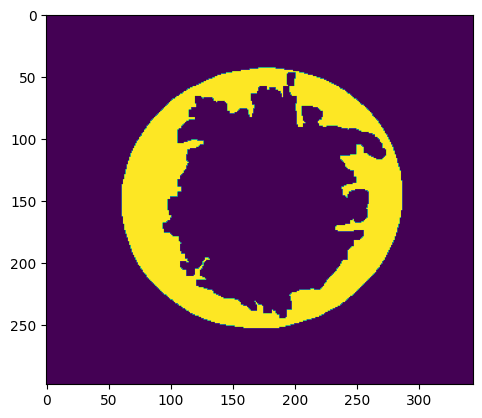

In [25]:
plt.imshow(te)

In [26]:
pred_te,pred_icm=[],[]
for path in files:
    te,icm = pipeline(path)
    pred_te.append(te)
    pred_icm.append(icm)

In [28]:
summary_metrics(gtruth_te,pred_te)

{'accuracy': 0.9159675160480817,
 'precision': 0.5881564295863893,
 'recall': 0.8946447928664762,
 'specificity': 0.9195132865387947,
 'jaccard': 0.5455586547684564,
 'dice': 0.7005932865159847}

In [29]:
summary_metrics(gtruth_icm,pred_icm)

{'accuracy': 0.9478805175085067,
 'precision': 0.6821848868976766,
 'recall': 0.6469625270651056,
 'specificity': 0.9725152995345732,
 'jaccard': 0.48917330593837943,
 'dice': 0.6342700942761716}

## Save predictions (ZP, TE, ICM) Saeedi dataset

In [ ]:
pred_te,pred_icm,zp=[],[],[]
for path in files:
    te,icm = pipeline(path)
    pred_te.append(te)
    pred_icm.append(icm)
    zp.append(zp_model(path))

In [49]:
save_path="image_processing/"
os.mkdir(save_path)
i=0
for f in files:
    f=Path(f)
    cv2.imwrite(save_path+f.name, pred_te[i]+150*(pred_icm[i]/255)+75*(zp[i]/255))
    i+=1

# INFERENCE

In [21]:
path='../img.png'
te,icm = pipeline(path)

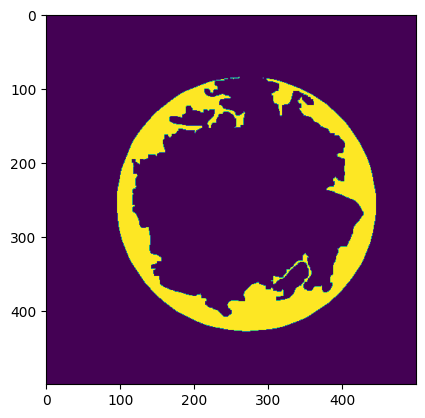

In [22]:
plt.imshow(te)

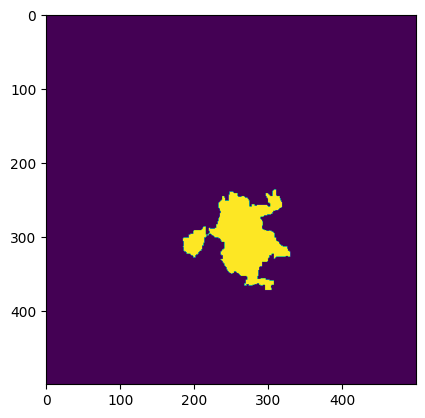

In [23]:
plt.imshow(icm)